In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters beautifulsoup4

In [46]:
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found in .env file")


In [1]:
import pandas as pd
import evaluate
from transformers import pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import DataFrameLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_openai import ChatOpenAI
import os
import getpass
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from langchain.llms import HuggingFaceHub

d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_reteriver() : 
    import pandas as pd
    ucsc_passage_df = pd.read_csv("passage.csv")
    ucsc_passge_data_loader = DataFrameLoader(ucsc_passage_df, page_content_column="passage")
    ucsc_passage_data = ucsc_passge_data_loader.load()
    text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=50)
    docs = text_splitter.split_documents(ucsc_passage_data)
    embeddings = HuggingFaceEmbeddings()
    db = FAISS.from_documents(docs, embeddings)
    return db.as_retriever()

In [3]:
from langchain.tools.retriever import create_retriever_tool

retriever = get_reteriver()
retriever_tool = create_retriever_tool(
    retriever,
    "UCSC_Information_Retriever",
    "Reterives information related to UCSC i.e University of California, Santa Cruz",
)

tools = [retriever_tool]

Created a chunk of size 265, which is longer than the specified 200
Created a chunk of size 1411, which is longer than the specified 200
Created a chunk of size 294, which is longer than the specified 200
Created a chunk of size 395, which is longer than the specified 200
Created a chunk of size 298, which is longer than the specified 200
Created a chunk of size 324, which is longer than the specified 200
Created a chunk of size 470, which is longer than the specified 200
Created a chunk of size 662, which is longer than the specified 200
Created a chunk of size 451, which is longer than the specified 200
Created a chunk of size 245, which is longer than the specified 200
Created a chunk of size 226, which is longer than the specified 200
Created a chunk of size 580, which is longer than the specified 200
Created a chunk of size 1970, which is longer than the specified 200
Created a chunk of size 617, which is longer than the specified 200
Created a chunk of size 312, which is longer t

In [4]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.managed.is_last_step import RemainingSteps
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """Holds the conversation messages and an optional counter for rewrite attempts."""
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    # messages: Sequence[BaseMessage] 

    # Optional counter for tracking how many times we've tried rewriting
    remaining_steps: RemainingSteps

In [5]:
def rewrite_guard(state: AgentState) -> str:
    """
    Increments the rewrite_attempts count in the state.
    If rewrite_attempts >= 3, we stop rewriting and route to 'generate'.
    Otherwise, we return 'agent' to try rewriting again.
    """
    # If rewrite_attempts not initialized, set to 0
    
    if state["remaining_steps"] <= 10:
        return "generate"
    else:
        return "agent"

    


In [6]:
searched_docs = [] 

In [7]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        # print("docs:", docs, type(docs))
        # searched_docs.append(docs)
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content
    
    searched_docs.append(docs)

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [8]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [55]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_conditional_edges(
    "rewrite",
    rewrite_guard,
    {
        "agent": "agent",
        "generate": "generate",
    }
)
workflow.add_edge("generate", END)


# Compile
graph = workflow.compile()

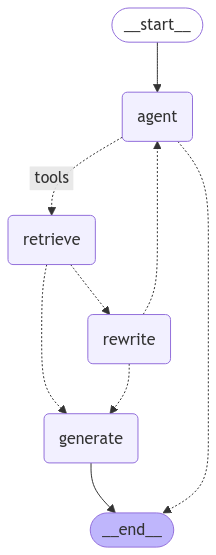

In [56]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [57]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the class sizes for the lower and upper division classes under the engineering school?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Iv5xDRuKjl8QNwAhBEhjgrWB', 'function': {'arguments': '{"query": "engineering school lower division class sizes"}', 'name': 'UCSC_Information_Retriever'}, 'type': 'function'}, {'index': 1, 'id': 'call_wh4b9FXdthg68Sy1zcrgBSm9', 'function': {'arguments': '{"query": "engineering school upper division class sizes"}', 'name': 'UCSC_Information_Retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_f17929ee92'}, id='run-2e8badd6-d5b7-4f3e-99a4-3ed7d69b840a-0', tool_calls=[{'name': 'UCSC_Information_Retriever', 'args': {'query': 'engineering school lower division class sizes'}, 'id': 'call_Iv5xDRuKjl8QNwAhBEhjgrWB', 'type': 'tool_call'}, {'name': 'UCSC_Information_Retriever', 'args': {'query': 'engineering school upper division class sizes'}, 'id': 'ca

d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'Class sizes for lower division classes in the engineering '
                'school can vary significantly, with larger introductory '
                'classes having anywhere from 15 to 400 students. In contrast, '
                'upper division classes tend to be smaller, often having fewer '
                'than 40 students. For specific data on class sizes, you can '
                'refer to the Instructional Activity Dashboard provided by UC '
                'Santa Cruz.']}
'\n---\n'


In [58]:
import pprint

inputs = {
    "messages": [
        ("user", "What are the class sizes for the lower and upper division classes under the engineering school?"),
    ]
}
message = ""
for output in graph.stream(inputs):
    for key, value in output.items():
        message = value
print(message["messages"][0])

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Class sizes for lower division classes in the engineering school can vary significantly, with larger introductory classes having anywhere from 15 to 400 students. In contrast, upper division classes tend to be smaller, often having fewer than 40 students. For specific data on class sizes, you can refer to the Instructional Activity Dashboard provided by UC Santa Cruz.


In [59]:
def get_final_answer(query):
    """
    Function to process a query and return the final answer using the RAG chain.
    
    Args:
        query (str): The query string to replace the placeholder question.

    Returns:
        str: The final answer from the RAG chain output.
    """
    inputs = {
        "messages": [
            ("user", query), 
        ]
    }

    
    output = graph.invoke(inputs)
    
    # Extract and return the final answer
    return output["messages"][-1].content


query = "What classes does the boating center offer to community members?"
answer = get_final_answer(query)
print("Final Answer:", answer)


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Final Answer: The UC Santa Cruz Community Boating Center offers classes for beginners and experienced individuals in sailing, rowing, and kayaking. They provide opportunities for skill development and water safety, catering to various experience levels. Additionally, they host junior summer camps and quarterly physical education classes for UC Santa Cruz students.


In [5]:
ucsc_qa_df = pd.read_csv("new_qa.csv", index_col=0)
ucsc_qa_df

,questions,answers,source_name,source,generated_response,source_docs
index,,,,,,
0,Who can be a member of the Boating Club?,Everyone is welcome to join! If you do not hav...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,Members of the Boating Club can include commun...,"Our club exists to give community members, UC ..."
1,What classes does the boating center offer to ...,We offer all levels of sailing (dinghy and kee...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The boating center offers classes for beginner...,UC Santa Cruz Community Boating Center is a co...
2,When is the boating club open?,"The club is open year-round, Saturday and Sund...",UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The boating club is open on Saturday and Sunda...,Boating Club Hours\r\nThe Community Boating Ce...
3,What boats are available to members?,Sailing vessels for weekend use currently incl...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,Members have access to the following sailing v...,Our boats:\r\nSailing vessels for weekend use ...
4,How much does a boating membership cost?,UCSC Student Membership: $45\r\nNon-Student Qu...,UCSC Boating Recreation FQAs,https://recreation.ucsc.edu/boating/faq.html,The provided context does not include any info...,There are a few minor fees associated with tak...
...,...,...,...,...,...,...
107,What if I don't fulfill the general education ...,If you don't satisfy general education require...,Undergraduate Admissions FAQ,https://admissions.ucsc.edu/resources-support/...,If you do not complete the IGETC or partial IG...,"By the end of the fall term prior to transfer,..."
108,What is UC TAP?,UC Transfer Admission Planner (UC TAP) is an o...,Undergraduate Admissions FAQ,https://admissions.ucsc.edu/resources-support/...,"UC TAP, or the UC Transfer Admission Planner, ...",UCSC TPP\r\nUCSC TAG Step-by-Step\r\nComplete ...
109,When are acceptance notices sent out?,"For fall quarter acceptance, notices are sent ...",Undergraduate Admissions FAQ,https://admissions.ucsc.edu/resources-support/...,The context does not specify when acceptance n...,First Year\t\r\nApplication Submission\r\n\r\n...


In [38]:
ucsc_qa_df[14:15]

,questions,answers,source_name,source,generated_response,source_docs
index,,,,,,
14,Am I eligible for UC SHIP if I've graduated?,"Yes, you can be covered for one additional qua...",UCSC Student Health Center FQAs,https://healthcenter.ucsc.edu/billing-insuranc...,The context does not provide information about...,Our campus also awards the UC Health Insurance...


In [62]:
searched_docs.clear()

In [64]:
len(searched_docs)


90

In [41]:
len(ucsc_qa_df['questions'])

112

In [63]:
agentic_rag_answers = []
count = 0
searched_docs.clear()
for question in ucsc_qa_df['questions']:
    print(f"Processing question: {question}")
    count += 1
    print(f"Question count: {count}")
    answer = get_final_answer(question)
    agentic_rag_answers.append(answer)


Processing question: Who can be a member of the Boating Club?
Question count: 1
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What classes does the boating center offer to community members?
Question count: 2
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: When is the boating club open?
Question count: 3
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What boats are available to members?
Question count: 4
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How much does a boating membership cost?
Question count: 5
---CALL AGENT---
Processing question: How do I sign up for a boating membership?
Question count: 6
---CALL AGENT---
Processing question: How can I join the Boating Club?
Question count: 7
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Are there additional fees to take out the boats after I join the boating club?
Question count: 8
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: Do the boating club rent Kayaks?
Question count: 9
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: How can I get involved with the Boating Club?
Question count: 10
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Why is health insurance required at UCSC?
Question count: 11
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do I get UC SHIP?
Question count: 12
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do I get my UC SHIP ID card?
Question count: 13
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Am I eligible if I opted out of UC SHIP last year?
Question count: 14
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: Am I eligible for UC SHIP if I've graduated? 
Question count: 15
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How much does UC SHIP cost?
Question count: 16
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Will financial aid pay for my UC SHIP?
Question count: 17
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Will Medi-Cal pay for my UC SHIP?
Question count: 18
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Can I do research at Baskin Engineering?
Question count: 19
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Is there going to be time for extracurricular activities?
Question count: 20
---CALL AGENT---
Processing question: How hard is it to get into undergrad classes?
Question count: 21
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What are the class sizes for the lower and upper division classes under the engineering school?
Question count: 22
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the diversity breakdown for engineering?
Question count: 23
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Is it hard to get help and talk to professors due to large class sizes? 
Question count: 24
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Which residential college is best for incoming engineering students?
Question count: 25
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What majors are housed in the school of engineering?
Question count: 26
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Can I switch into computer science if I was accepted into another engineering program?
Question count: 27
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What relationship does Baskin Engineering have with tech in Silicon Valley?
Question count: 28
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What companies collaborate with the engineering school?
Question count: 29
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What internship opportunities are available to students?
Question count: 30
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What are the employment rates of new graduates?
Question count: 31
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Does UCSC offer a ____ major? How is the ___ major at UC Santa Cruz?
Question count: 32
---CALL AGENT---
Processing question: Does UCSC offer a pre-med program? A business program? What about preparation to become a teacher?
Question count: 33
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: May I apply to UCSC with an undeclared major? When must I declare a major?
Question count: 34
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do you use alternate majors from the UC Application?
Question count: 35
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Can I double major?
Question count: 36
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How large are classes?
Question count: 37
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What are the graduation requirements?
Question count: 38
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What opportunities are there for early graduation?
Question count: 39
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What support do first-year students have? Do they have advisers?
Question count: 40
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What honors courses or programs are available?
Question count: 41
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How can I get a UC Santa Cruz catalog?
Question count: 42
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is UC Santa Cruz's grading policy for undergraduates?
Question count: 43
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What classes does UCSC Extension Silicon Valley provide?
Question count: 44
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How are you making your admissions decisions?
Question count: 45
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Did you admit any out-of-state or international students?
Question count: 46
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Does UCSC have a waitlist?
Question count: 47
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: If I was not selected for admission, may I appeal the decision?
Question count: 48
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is Dual Admission?
Question count: 49
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do you make your admissions decisions?
Question count: 50
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Is choice of major one of your criteria for admission/selection?
Question count: 51
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: I want to change the major that I listed on my application. Is that possible?
Question count: 52
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Do you take fall term grades into account?
Question count: 53
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Do you give any preference for local students?
Question count: 54
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: How are you able to let some students know their decision before other students?
Question count: 55
---CALL AGENT---
Processing question: Do you take any out-of-state or international students?
Question count: 56
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: I think you made a mistake and I'd like to appeal. Do you have an appeals process?
Question count: 57
---CALL AGENT---
Processing question: I don't want to appeal because I think a mistake has been made. Can you tell me how I can get your decision changed?
Question count: 58
---CALL AGENT---
Processing question: Have you set aside a specific number of admission spaces for appeal cases?
Question count: 59
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: When will I know a decision on my appeal?
Question count: 60
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: If my appeal for fall admission is denied, what are my chances for winter admission?
Question count: 61
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: Does UCSC have a waitlist?
Question count: 62
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Can I apply for spring quarter?
Question count: 63
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the waitlist?
Question count: 64
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How will I know that I've been offered a place on the UCSC waitlist?
Question count: 65
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: I had good grades and took a broad range of challenging courses at my prior high school or community college. Why wasn’t I admitted?
Question count: 66
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Am I on the waitlist automatically?
Question count: 67
---CALL AGENT---
Processing question: If I am on the waitlist for UCSC, what are my chances of being admitted?
Question count: 68
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What number am I on the waitlist?
Question count: 69
---CALL AGENT---
Processing question: How will I find out if I get an offer of admission?
Question count: 70
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What if I already accepted an offer to another UC campus?
Question count: 71
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Can I be on a waitlist for more than one UC campus?
Question count: 72
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What if I am on the waitlist for UCSC, and I receive an offer from another university outside the University of California system?
Question count: 73
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: If I’m admitted from the waitlist, will I still be eligible for financial aid?
Question count: 74
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: If I’m admitted from the waitlist, will I get my first-choice residential college?
Question count: 75
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: Can I change the college I was assigned to?
Question count: 76
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do I apply for admission for fall or winter quarters?
Question count: 77
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What standardized tests do I need to take?
Question count: 78
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the acceptance rate?
Question count: 79
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Do students from the East Coast have a greater chance of being accepted than West Coast students?
Question count: 80
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: What is your AP policy?
Question count: 81
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: When are acceptance notices sent out?
Question count: 82
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the application and admission process for student athletes?
Question count: 83
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What kinds of athletics and intramural programs are there?
Question count: 84
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: Does UC Santa Cruz offer any athletics scholarships or financial aid?
Question count: 85
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the level of competition in UC Santa Cruz athletics?
Question count: 86
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: How difficult is it to make an NCAA Division III team?
Question count: 87
---CALL AGENT---
Processing question: How are the athletics facilities at UC Santa Cruz?
Question count: 88
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Does UC Santa Cruz have a housing guarantee?
Question count: 89
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the college system?
Question count: 90
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do I request affiliation with a college and can I change it?
Question count: 91
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Does my college affiliation affect what classes I can take?
Question count: 92
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What services are in place to help me find off-campus housing?
Question count: 93
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do I apply for Family Student Housing?
Question count: 94
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What types of financial aid are available?
Question count: 95
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the Blue and Gold Opportunity Plan?
Question count: 96
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the Middle Class Scholarship?
Question count: 97
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What other financing options are available?
Question count: 98
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How do I apply for financial aid?
Question count: 99
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How much financial aid is offered for out-of-state students?
Question count: 100
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: How much financial aid is offered for international students?
Question count: 101
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What if I don't qualify for financial aid?
Question count: 102
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
Processing question: What student clubs and organizations are active at Santa Cruz?
Question count: 103
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What kinds of arts and entertainment does the campus offer?
Question count: 104
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Are there any selective majors at UC Santa Cruz?
Question count: 105
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What kinds of courses can I transfer?
Question count: 106
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is the maximum number of credits I can transfer into UC Santa Cruz with?
Question count: 107
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What if I don't fulfill the general education requirements before I transfer?
Question count: 108
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What is UC TAP?
Question count: 109
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: When are acceptance notices sent out?
Question count: 110
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: What are the Cross-Campus and Simultaneous Enrollment programs?
Question count: 111
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Processing question: Can I talk to an adviser during a campus visit?
Question count: 112
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


d:\AIEA Lab\LLM Logic\Agentic-RAG\venv\lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [65]:
# list = "4 5 7 8 13 31 53 54 56 57 58 60 64 66 68 74 76 79 83 86 111".split(" ")
# list = "5 6 8 9 14 30 32 54 55 57 58 59 61 65 69 80 84 86 87 102".split(" ")
list = "5 6 8 9 14 20 32 54 55 57 58 59 61 65 67 69 75 80 84 86 87 102".split(" ")
print(list)
for i in list:
    print(agentic_rag_answers[int(i) - 1])

['5', '6', '8', '9', '14', '20', '32', '54', '55', '57', '58', '59', '61', '65', '67', '69', '75', '80', '84', '86', '87', '102']
It seems like you're asking about a boating membership, but you didn't specify where or what type of boating club or organization you're interested in. Boating memberships can vary widely in cost depending on the location, the type of boats available, the amenities offered, and the level of membership. Could you provide more details or specify a particular boating club or location?
To assist you better, could you please specify where you are looking to sign up for a boating membership? For example, are you interested in a local yacht club, a national boating organization, or a specific marina's boating club? This will help me provide you with the most relevant information.
After joining the boating club at UCSC, there are a few additional fees for taking out boats:

1. **Guest Fees:**
   - **Student Guest Fee:** $5
   - **Non-Student Guest Fee:** $10
   - Gu

In [45]:
agentic_rag_answers[42]

"I don't know."

In [66]:
len(agentic_rag_answers)

112

In [73]:
idx_list = []
ans_list = []
for i, item in enumerate(agentic_rag_answers):
    if item == "I don't know.":
        idx_list.append(i)
        continue
    ans_list.append(item)

print(len(ans_list))
print(idx_list)


110
[42, 80]


In [7]:
ucsc_qa_df['questions'][41]

'How can I get a UC Santa Cruz catalog?'

In [ ]:
indexList = [14, 21, 42, 53, 80, 81, 109]
ragGen_ans_list = ucsc_qa_df["generated_response"].tolist()
for i in indexList:
    print(f"Question: {ucsc_qa_df['questions'][i]}")
    print(f"Answer: {ucsc_qa_df['answers'][i]}")
    print(f"Agentic Answer: {agentic_rag_answers[i]}")
    print(f"RAG Generated Answer: {ragGen_ans_list[i]}")
    print("\n")

Question: Am I eligible for UC SHIP if I've graduated? 
Answer: Yes, you can be covered for one additional quarter if you've graduated and you had UC SHIP in the previous quarter. Students who graduate in June are still covered by UC SHIP if they had UC SHIP in the spring quarter; this coverage lasts until the start of the next academic calendar year. To enroll and purchase, complete the Continuation Voluntary Enrollment forms in the Insurance Forms & Helpful Links.
Agentic Answer: I don't know.
RAG Generated Answer: The context does not provide information about eligibility for UC SHIP for individuals who have graduated. It specifically discusses eligibility for undergraduate financial aid applicants and requirements for junior transfer admissions. Therefore, based on the provided context, it cannot be determined if you would be eligible for UC SHIP after graduation.


Question: What are the class sizes for the lower and upper division classes under the engineering school?
Answer: Ann

In [27]:
df = pd.DataFrame(agentic_rag_answers, columns=["agenticragoutput"])

# Write the DataFrame to a CSV file without writing the default index
df.to_csv("AgenticRAGoutputNew.csv", index=False)

In [28]:
#load csv file and display the data
df = pd.read_csv("AgenticRAGoutputNew.csv")
df

,agenticragoutput
0,Members of the Boating Club can include commun...
1,The UC Santa Cruz Community Boating Center off...
2,The boating club is open on Saturday and Sunda...
3,Members have access to a variety of sailing ve...
4,It seems like you're asking about the cost of ...
...,...
107,If you don't fulfill the general education req...
108,"UC TAP, or the UC Transfer Admission Planner, ..."
109,Acceptance notices for fall quarter are sent o...
110,The Cross-Campus Enrollment program allows UCS...


In [29]:
src_ans_list = ucsc_qa_df['answers'].tolist()
generated_ans_list = agentic_rag_answers

In [30]:
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

In [31]:
bleu_results = bleu.compute(predictions=generated_ans_list, references=src_ans_list)
bleu_results

{'bleu': 0.07792995297653334,
 'precisions': [0.28218937875751504,
  0.0938770325203252,
  0.04690721649484536,
  0.029680962343096234],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2942130004863024,
 'translation_length': 7984,
 'reference_length': 6169}

In [32]:
rouge_results = rouge.compute(predictions=generated_ans_list, references=src_ans_list)
rouge_results

{'rouge1': 0.3136198034862087,
 'rouge2': 0.11768140747437175,
 'rougeL': 0.216936495115884,
 'rougeLsum': 0.22335066362474942}

In [69]:
src_ans_list = []
gen_ans_list = []
question_list = []
for i in range(112):
    if str(i + 1) in list:
        continue
    src_ans_list.append(ucsc_qa_df['answers'][i])
    gen_ans_list.append(agentic_rag_answers[i])
    question_list.append(ucsc_qa_df['questions'][i])

len(src_ans_list), len(gen_ans_list), len(searched_docs) , len(question_list)

(90, 90, 90, 90)

In [ ]:
# src_ans_list = ucsc_qa_df['answers'].tolist()
# gen_ans_list = ucsc_qa_df["generated_response"].tolist()
# source_doc_list =  ucsc_qa_df["source_docs"].tolist()
# question_list = ucsc_qa_df["questions"].tolist()

In [70]:
print("Source Answer: ", type(src_ans_list[0]))
print("Generated Answer: ", gen_ans_list[0])
print("Source Docs: ", searched_docs[0])
print("Question: ", question_list[0])

Source Answer:  <class 'str'>
Generated Answer:  Members of the Boating Club can include community members, UC Santa Cruz students, faculty, and staff. They have access to sailing and rowing vessels under the supervision of the Boating Center dockmaster. Membership requires approval for boat use based on experience.
Source Docs:  How can I join the Boating Club?

The boating club exists to give community members, UC Santa Cruz students, faculty, and staff access to equipment that makes it possible to enjoy our beautiful Monterey Bay. The club provides members a unique opportunity to use any number of sailing and rowing vessels under the weekend supervision of the Boating Center dockmaster.

Our club exists to give community members, UC Santa Cruz students, faculty, and staff access to equipment that makes it possible to enjoy our beautiful Monterey Bay. The club provides members a unique opportunity to use any number of sailing and rowing vessels under the weekend supervision of the Bo

In [ ]:
len(src_ans_list), len(gen_ans_list), len(searched_docs) , len(question_list)

In [71]:
import os
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)


# Define the questions, ground truth answers, generated answers, and retrieved contexts
questions = question_list
ground_truth_answers = src_ans_list
generated_answers = gen_ans_list
retrieved_contexts = [docs.split("\n\n") for docs in searched_docs]


# Create a dataset compatible with Ragas
data = {
    "question": questions,
    "ground_truth": ground_truth_answers,
    "answer": generated_answers,
    "retrieved_contexts": retrieved_contexts,
}
dataset = Dataset.from_dict(data)

metrics = [faithfulness, answer_relevancy, context_recall, context_precision]

results = evaluate(dataset, metrics=metrics, raise_exceptions=False)


results_df = results.to_pandas()

# Display the evaluation results
print(results_df)


Evaluating: 100%|██████████| 360/360 [03:50<00:00,  1.56it/s]


                                           user_input  \
0            Who can be a member of the Boating Club?   
1   What classes does the boating center offer to ...   
2                      When is the boating club open?   
3                What boats are available to members?   
4                    How can I join the Boating Club?   
..                                                ...   
85  What if I don't fulfill the general education ...   
86                                    What is UC TAP?   
87              When are acceptance notices sent out?   
88  What are the Cross-Campus and Simultaneous Enr...   
89    Can I talk to an adviser during a campus visit?   

                                   retrieved_contexts  \
0   [How can I join the Boating Club?, The boating...   
1   [UC Santa Cruz Community Boating Center is a c...   
2   [Boating Club Hours\nThe Community Boating Cen...   
3   [Our boats:\nSailing vessels for weekend use c...   
4   [How can I join the Boatin

In [72]:
average_scores = results_df[['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']].mean()

# Display the average scores
print("Average Scores:")
print(average_scores)

Average Scores:
faithfulness         0.864990
answer_relevancy     0.798556
context_recall       0.524074
context_precision    0.645632
dtype: float64
